### FaceNet 30
### by Gunawan
#### Dataset: LESS DATASET WITH BIGGER RESOLUTION
#### 2 old TW woman, 1 old Japan woman, 1 old KR woman, 1 young TW woman <-COMBINED INTO EAST ASIAN WOMAN
#### ALL young girls from 4 different country:
- Ayana from Korea
- Park Bo from Korea
- Maki from Japan
- Chen shi from TW

## HAVE BEEN ADDED TO NEW CATEGORY: East Asia Girls

#### ALL 4 old mans from 4 different country:
- Ma from TW
- Abe from JP
- Moon From KR
- Leung from HK

## HAVE BEEN ADDED TO NEW CATEGORY: East Asia Man

Now I add 3 Young East Asian 

## HAVE BEEN ADDED TO NEW CATEGORY: East Asia Young  Man

Now I add 2 Eur Ladies 

#### each 9 training and 2 testing (total 11 each) 

FaceNet suggests one of 6 Neural Network architectures - This is NN4 Small - an Inception model with 96x96 images as input  

![image.png](attachment:image.png)

The input is 96x96x3 and the output is a 128d vector 

**Note: the last layer normalizes the embedding to be on the d-dim hyper sphere, with a distance of 1 from the 0-vector)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Copy the PY files into working dir

In [2]:
from shutil import copyfile
copyfile(src = "/content/drive/MyDrive/Facenet_Kit/align.py", dst = "/content/align.py")
copyfile(src = "/content/drive/MyDrive/Facenet_Kit/data.py", dst = "/content/data.py")
copyfile(src = "/content/drive/MyDrive/Facenet_Kit/model.py", dst = "/content/model.py")
copyfile(src = "/content/drive/MyDrive/Facenet_Kit/utils.py", dst = "/content/utils.py")

'/content/utils.py'

# Use the PY files

In [3]:
from model import create_model
nn4_small2 = create_model()
nn4_small2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set. The triplet loss in Keras is best implemented with a custom layer as the loss function doesn't follow the usual `loss(input, target)` pattern. This layer calls `self.add_loss` to install the triplet loss:

In [4]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [5]:
nn4_small2_train.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          3743280     input_2[0][0]                    
                                                                 input_3[0][0]              

In [6]:
from data import triplet_generator

generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')

#nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100) <-- DEPRECATED
nn4_small2_train.fit(generator, epochs=10, steps_per_epoch=100)


Epoch 1/10
100/100 [==============================] - 86s 63ms/step - loss: 0.8285
Epoch 2/10
100/100 [==============================] - 6s 63ms/step - loss: 0.7993
Epoch 3/10
100/100 [==============================] - 6s 63ms/step - loss: 0.8233
Epoch 4/10
100/100 [==============================] - 6s 63ms/step - loss: 0.8012
Epoch 5/10
100/100 [==============================] - 6s 63ms/step - loss: 0.8000
Epoch 6/10
100/100 [==============================] - 6s 63ms/step - loss: 0.8004
Epoch 7/10
100/100 [==============================] - 6s 62ms/step - loss: 0.7999
Epoch 8/10
100/100 [==============================] - 6s 62ms/step - loss: 0.7995
Epoch 9/10
100/100 [==============================] - 6s 62ms/step - loss: 0.7994
Epoch 10/10
100/100 [==============================] - 6s 63ms/step - loss: 0.8002


In [7]:
copyfile(src = "/content/drive/MyDrive/Facenet_Kit/models/landmarks.dat", dst = "/content/landmarks.dat")
copyfile(src = "/content/drive/MyDrive/Facenet_Kit/weights/nn4.small2.v1.h5", dst = "/content/nn4.small2.v1.h5")


'/content/nn4.small2.v1.h5'

# Using a pre-trained OpenFace model on a custom dataset

Implementation of FaceNet trained on the public datasets FaceScrub and CASIA-WebFace

## Load the pre-trained model

In [8]:
from model import create_model
nn4_small2_pretrained = create_model()

nn4_small2_pretrained.load_weights('nn4.small2.v1.h5')

## Prep the dataset

In [9]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [10]:
metadata = load_metadata('/content/drive/MyDrive/DS_30_Train')
metadata2 = load_metadata('/content/drive/MyDrive/DS_30_Test')
#metadata = load_metadata('/content/data_celeb01_train_val/') <-- NOT THIS (IN KAGGLE case)
#/content/drive/MyDrive/ds_19_train

In [11]:
#import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('landmarks.dat')
#alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    # Load an image
    original = load_image(metadata[img_index].image_path())

    # Detect face and return bounding box
    bb = alignment.getLargestFaceBoundingBox(original)

    # Transform image using specified face landmark indices and crop image to 96x96
    aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

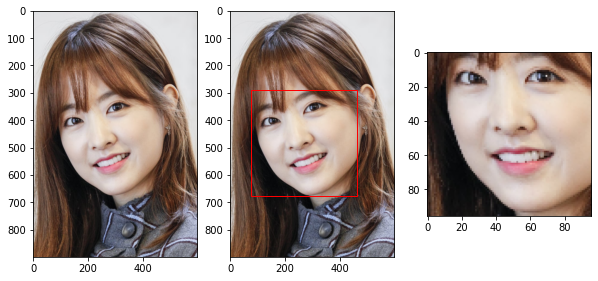

In [12]:
show_original_and_aligned(20)

In [13]:
#define for using in the future

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Generate Embedding Vectors

In [14]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())    
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    try:
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
      progress.update(i)
    except:
      pass

- |         #                                       | 208 Elapsed Time: 0:03:16

In [15]:
from progressbar import ProgressBar

num_images_test = metadata2.shape[0]
progress = ProgressBar(num_images_test)
progress.start()

embedded_test = np.zeros((num_images_test, 128))

for i, m in enumerate(metadata2):
    #print(m.image_path())    
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    try:
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded_test[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
      progress.update(i)
    except:
      pass

\ |                                               #  | 45 Elapsed Time: 0:00:45

In [16]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

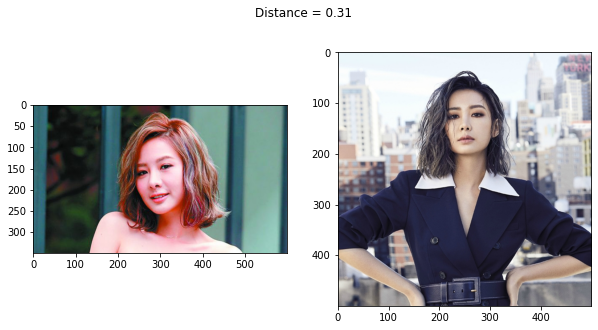

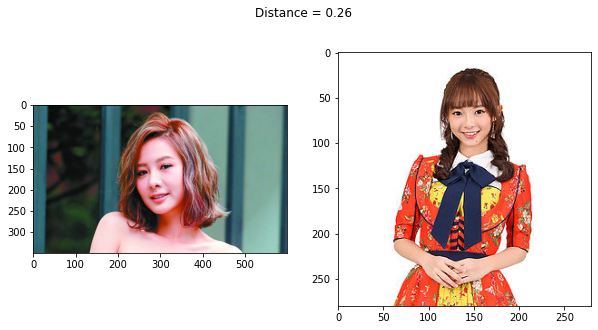

In [17]:
show_pair(1,2)
show_pair(1,10)

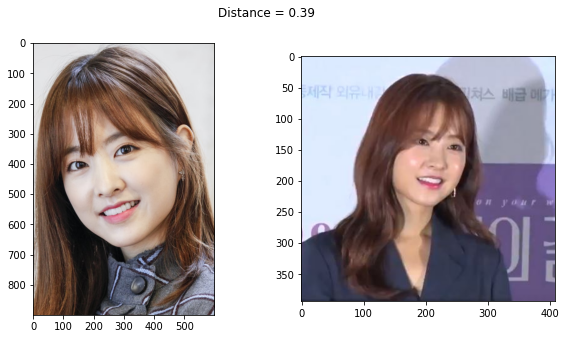

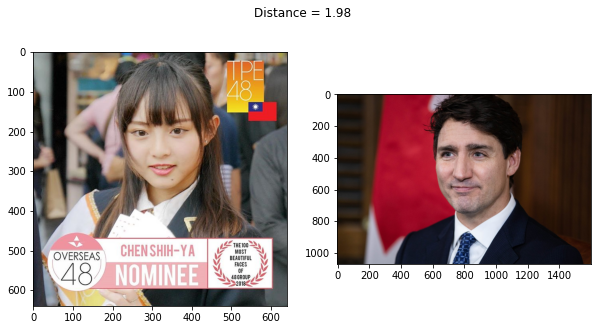

In [19]:
show_pair(20,21)
show_pair(13,140)

# What is the best threshold for the verification problem (Distance Treshold)

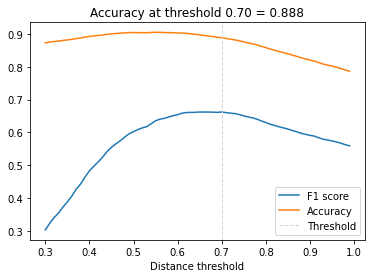

In [20]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

## Distance distributions of positive and negative pairs

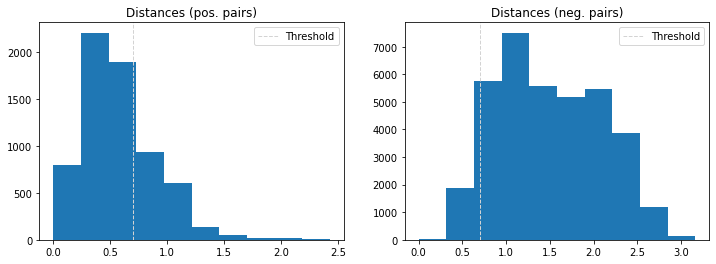

In [21]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Face recognition - with KNN or an SVM

50% used for training  
50% for validation

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

targets_test = np.array([n.name for n in metadata2])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)
y2 = encoder.transform(targets_test)

#test_idx = np.arange(metadata.shape[0]) % 2 != 0
#train_idx = np.arange(metadata.shape[0]) % 2 == 0
test_idx = np.arange(metadata2.shape[0]) % 1 == 0
train_idx = np.arange(metadata.shape[0]) % 1 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded_test[test_idx]

y_train = y[train_idx]
y_test = y2[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

y_pred_svc = svc.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9782608695652174, SVM accuracy = 1.0


In [23]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata2[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded_test[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata2[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded_test[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

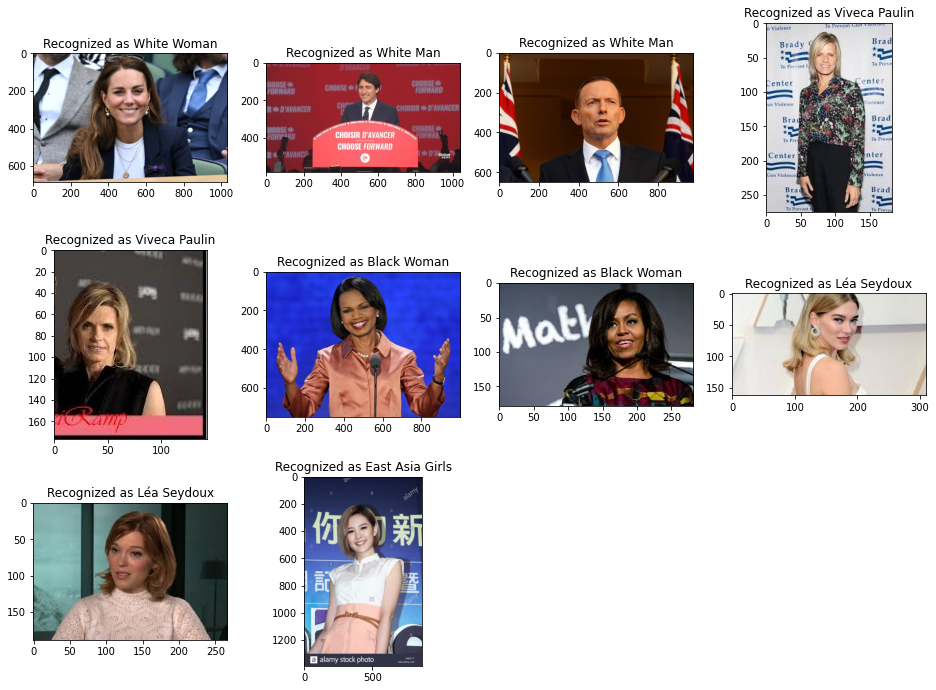

In [24]:
show_predictions(range(1,11))

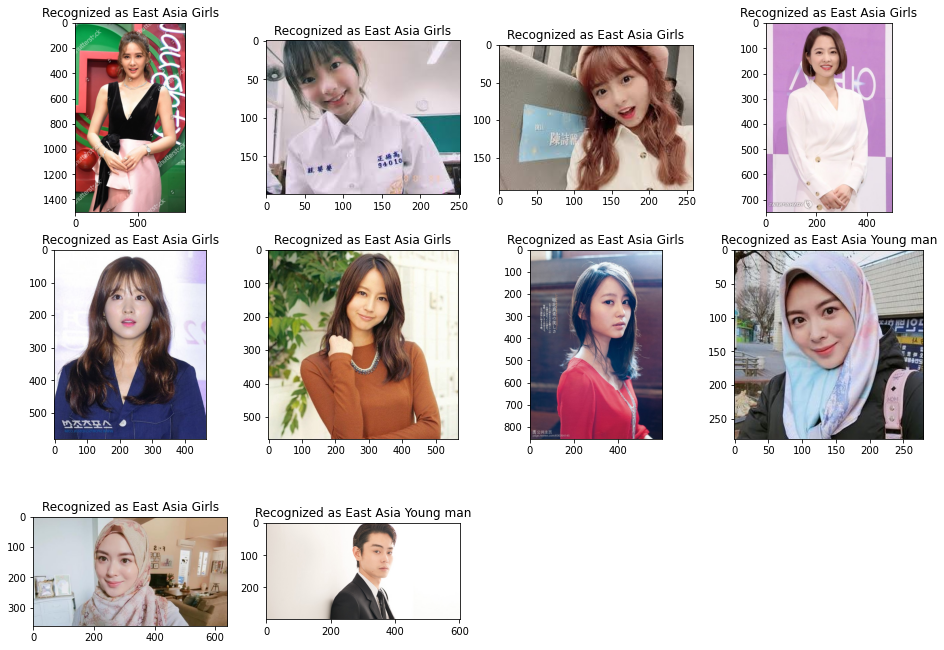

In [31]:
show_predictions(range(11,21))
#.......................^Starting
#..........................^Not included

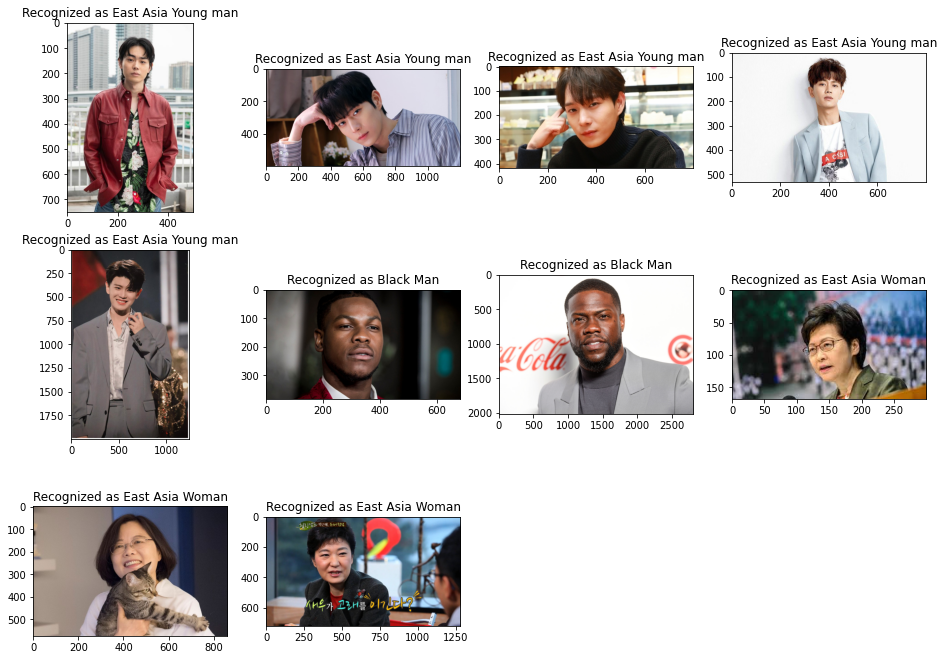

In [32]:
show_predictions(range(21,31))
#.......................^Starting
#..........................^Not included

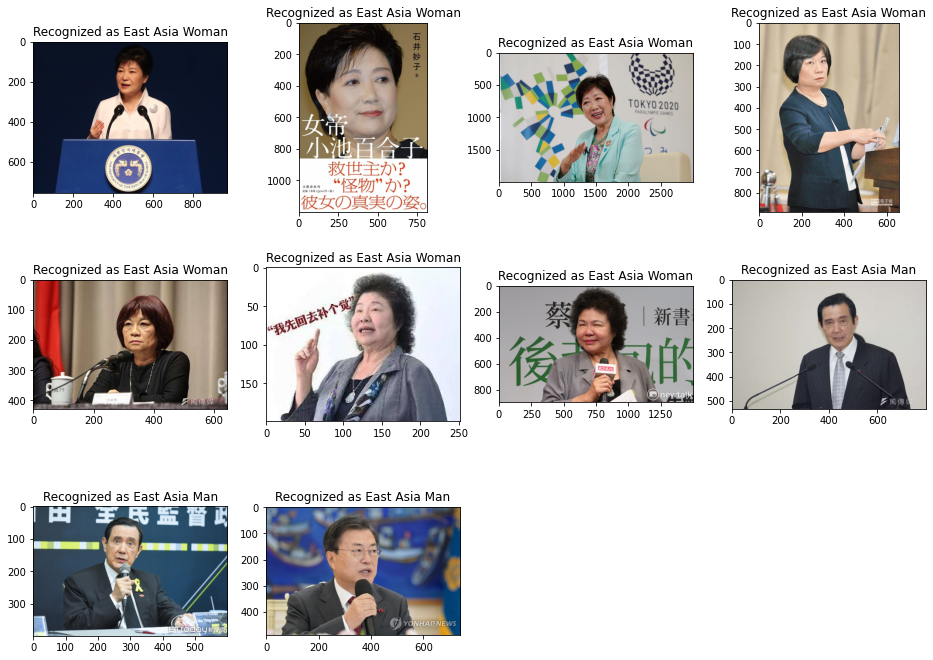

In [33]:
show_predictions(range(31,41))
#.......................^Starting
#..........................^Not included

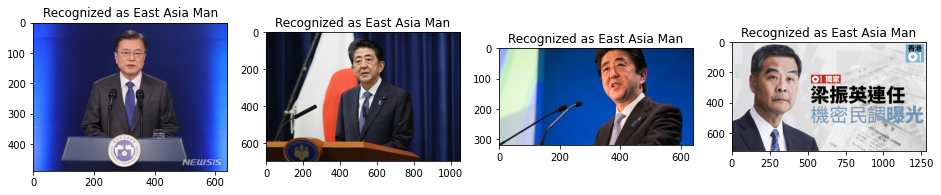

In [35]:
show_predictions(range(41,45))
#.......................^Starting
#..........................^Not included

## Missclassified images

[18]


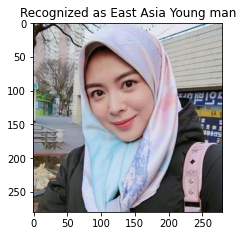

In [27]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


In [28]:
error_pairs = []

for i, item in enumerate(y_pred_svc):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


[]


<Figure size 1152x1152 with 0 Axes>

# Dataset visualization

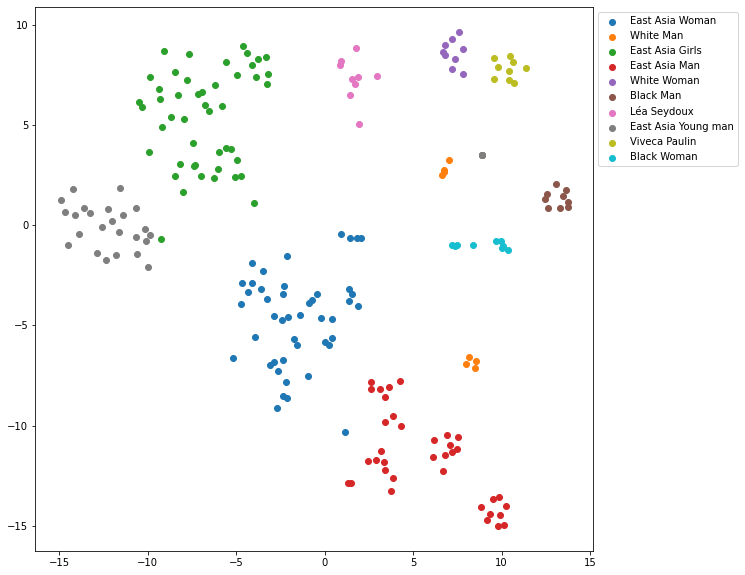

In [30]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [36]:
from sklearn.metrics import plot_confusion_matrix


KNN CONFUSION MATRIX
KNN Confusion matrix, without normalization
[[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  1  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  2]]
KNN Normalized confusion matrix
[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.9 0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


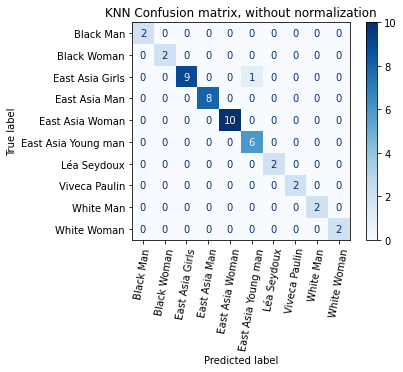

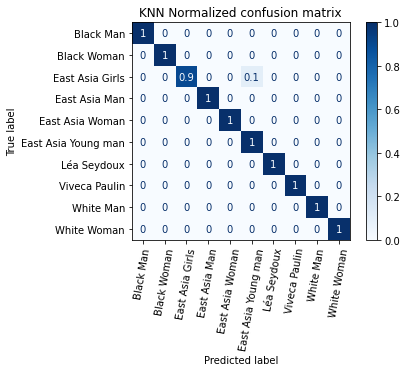

In [37]:
#class_names = ['AFR.','ARAB','ASN','CAUC.','EAS','INDI']
#class_names = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
#class_names = ['Angelina_Jolie',
# 'Bill_Clinton''Bill_Gates','Britney_Spears','Catherine_Zeta-Jones','David_Beckham','Jackie_Chan','Salma_Hayek','Sandra_Bullock',
#'Serena_Williams','Tess_Ferrandez','Tiger_Woods','Tim_Scarfe','Tom_Cruise','Tom_Hanks','Venus_Williams']
# Plot non-normalized confusion matrix
#class_names = ['Female','Female w/ Mask','Male','Male w/ Mask']

#class_names = ['EA F','EA M','EUR F','EUR M']
print('KNN CONFUSION MATRIX')
class_names = list(np.unique(targets_test))

titles_options = [("KNN Confusion matrix, without normalization", None),
                  ("KNN Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 xticks_rotation=80)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        10
           5       0.86      1.00      0.92         6
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           0.98        46
   macro avg       0.99      0.99      0.99        46
weighted avg       0.98      0.98      0.98        46



In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



SVM CONFUSION MATRIX
SVM Confusion matrix, without normalization
[[ 2  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  2]]
SVM Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


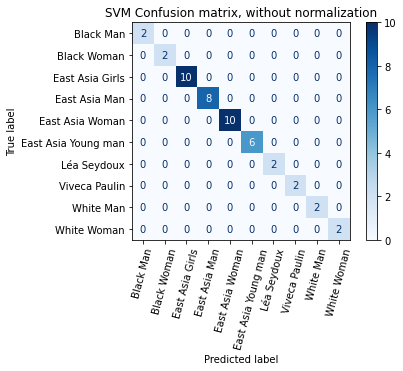

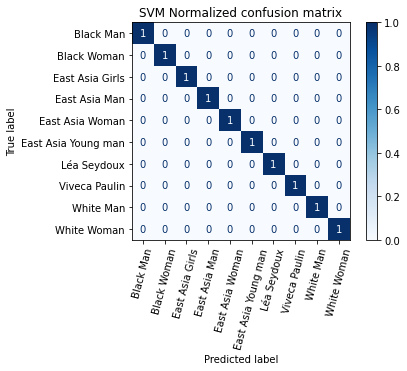

In [40]:
# Plot non-normalized confusion matrix
#class_names = ['AFR.','ARAB','ASN','CAUC.','EAS','INDI']
#class_names = ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9']
print('SVM CONFUSION MATRIX')
titles_options = [("SVM Confusion matrix, without normalization", None),
                  ("SVM Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize,
                                 xticks_rotation=75)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()